### Model Design

In [1]:
import torch
import torch.nn as nn
import torch.optim.lr_scheduler as lr_scheduler

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [2]:
country = 'India'
# Import the data convereted from series format to Time series
df_reframed = pd.read_csv(f'./data/reshaped_data/{country}_reframed.csv', index_col='year')
# df_reframed = df_reframed.round(4)
df_reframed.columns

Index(['latnum', 'longnum', 'URBAN_RURA', 'pfir', 'country', 'dhsregna',
       'ndvi_1', 'ndvi_2', 'ndvi_3', 'ndvi_4', 'ndvi_5', 'ndvi_6', 'ndvi_7',
       'ndvi_8', 'ndvi_9', 'ndvi_10', 'ndvi_11', 'ndvi_12', 'ntl', 't_1',
       't_2', 't_3', 't_4', 't_5', 't_6', 't_7', 't_8', 't_9', 't_10', 't_11',
       't_12', 'rf_1', 'rf_2', 'rf_3', 'rf_4', 'rf_5', 'rf_6', 'rf_7', 'rf_8',
       'rf_9', 'rf_10', 'rf_11', 'rf_12', 'next_pfir'],
      dtype='object')

In [3]:
df_reframed.shape

(511110, 44)

In [4]:
# Normalizing the Malaria index columns between 0,1
max = df_reframed.iloc[:,-1].abs().max()
print(max)
df_rescaled = df_reframed.copy()
df_rescaled.iloc[:,-1] = df_reframed.iloc[:,-1] /max
df_rescaled.iloc[:,-1].abs().max()
df_rescaled.shape

0.509214


(511110, 44)

In [5]:
# Returns number of batches for the total data provided to the function
def getNoOfBatches(batch_size, dataset_size):
    return int(dataset_size/18)
# Returns two data frames X:(Features of all Examples reshaped into batches) and Y:(Target of all Examples turned into batches)
def getBatches(df:pd.DataFrame, batch_size=1):
    df_ref = df.values

    Y = df_ref[:, -1]
    Y = Y.reshape(Y.shape[0], 1)
    X = df_ref[:, :df_ref.shape[1]-1]
    # Here batch size indicates the number of timestamps/ No. of years
    no_batches = getNoOfBatches(batch_size = batch_size, dataset_size = X.shape[0])

    X = X.reshape(no_batches, batch_size, X.shape[1])
    Y = Y.reshape(no_batches, batch_size, Y.shape[1])
    return X, Y
def get_preprocessed_data(df:pd.DataFrame, batch_size=1):
    X, Y = getBatches(df_reframed, batch_size=18)
    
    X_reshaped = []
    for i in range(X.shape[0]):
        X_reshaped.append(np.delete(X[i], -1, axis=0))
    X_reshaped = np.asarray(X_reshaped)
    
    Y_reshaped = []
    for i in range(Y.shape[0]):
        y=[]
        for j in range(Y.shape[1]):
            if j<17: y.append(Y[i][j+1][0])
        Y_reshaped.append(y)
    
    Y_reshaped = np.asarray(Y_reshaped)
    Y_reshaped = Y_reshaped.reshape(Y_reshaped.shape[0], Y_reshaped.shape[1], 1)
    return X_reshaped, Y_reshaped

In [6]:
torch.set_default_dtype(torch.double) 
batch_size = 17
dataset_size = df_reframed.shape[0]
example_size = getNoOfBatches(batch_size ,dataset_size)
print(example_size)
X_1, Y_1 = get_preprocessed_data(df_reframed, batch_size = batch_size)
# Converting the dtype of X_1, Y_1 from pd.DataFrame to torch.tensor
X_1, Y_1 = torch.tensor(X_1), torch.tensor(Y_1)
print(f'X_1 shape: {X_1.shape} | Y_! shape: {Y_1.shape}')

28395
X_1 shape: torch.Size([28395, 17, 43]) | Y_! shape: torch.Size([28395, 17, 1])


In [7]:
import random
example_lst = [i for i in range(example_size)]
# example_lst = random.shuffle(example_lst)
example_lst = random.sample(example_lst,example_size)


In [8]:
# Dividing into training and testing datasets
train_split = 0.8
train_values = train_split * example_size
train_values = int(train_values)
split_type = 'Spatial'
train_X, test_X = X_1[example_lst[:train_values],:], X_1[example_lst[train_values:],:]
train_y, test_y = Y_1[example_lst[:train_values], :], Y_1[example_lst[train_values:], :]
print(train_values)
# print(example_lst[train_values:])
print(train_y.shape)

22716
torch.Size([22716, 17, 1])


In [9]:
class MultivariateLSTM(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(MultivariateLSTM, self).__init__()

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        
        out, _ = self.lstm(x)
        out = self.fc1(out)
        out = out[:, -1, :]
        return out

In [10]:
input_size = X_1.shape[-1] # The number of expected features in the input
hidden_size = 100 # The number of hidden states 
num_layers = 4 # Number of Hidden layers
output_size = 1
lr=0.0001

# Initializing a model Object
model = MultivariateLSTM(input_size, hidden_size, num_layers, output_size=1)
# Defining loss function
criterion = nn.L1Loss()
# Selecting an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# Creating a schedular for adaptive learning rate
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=0.3, total_iters=10)

In [11]:
# Load the model if saved already in params folder
outputs = 0
epochs = 10
loss = 0
losses = []
# In case you are loading the model, his variable specifies the number of epochs used in previously
previous_epochs = 0
# Stores count of current epochs plus previous ones
loaded_model_epochs = epochs+previous_epochs

if previous_epochs!=0:
    loaded_params = torch.load(f'./Saved_Params/{country}_{str(loaded_model_epochs)}_{str(num_layers)}_{str(hidden_size)}_ep_trained.pt')
    
    previous_epochs = loaded_params['checkpoint_epoch']
    loaded_loss = loaded_params['checkpoint_loss']
    loaded_model = loaded_params['model_state_dict']
    loaded_optimizer = loaded_params['optim_state_dict']

    loss = loaded_loss
    model.load_state_dict(loaded_model)
    optimizer.load_state_dict(loaded_optimizer)
    

In [12]:
print('Training...LSTM')

epochs = [i+1 for i in range(epochs)]
for epoch in epochs:
    train_loss = 0.0
    for i in range(train_X.shape[0]):
        
        input_batch, target_batch = train_X[i], train_y[i]
        input_batch = input_batch.reshape(-1, input_batch.shape[0], input_batch.shape[1])
        
        outputs = model(input_batch)[0]
        target = target_batch[-1]
        loss = criterion(outputs, target)
        optimizer.zero_grad()
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * input_batch.size(0)
    scheduler.step()
    
    train_loss /= train_X.shape[0]
    losses.append(train_loss)  
    if epoch%1 == 0: print(f'Epoch {epoch+previous_epochs}/{previous_epochs+epochs[-1]}, Train Loss: {train_loss:.6f}')
epochs = len(epochs)
print('Training Ended!')

Training...LSTM
Epoch 1/10, Train Loss: 0.009249
Epoch 2/10, Train Loss: 0.008949
Epoch 3/10, Train Loss: 0.008682
Epoch 4/10, Train Loss: 0.008537
Epoch 5/10, Train Loss: 0.008444
Epoch 6/10, Train Loss: 0.008399
Epoch 7/10, Train Loss: 0.008375
Epoch 8/10, Train Loss: 0.008418
Epoch 9/10, Train Loss: 0.008463
Epoch 10/10, Train Loss: 0.008407
Training Ended!


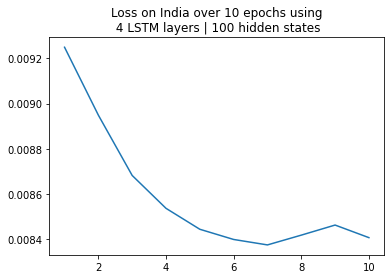

In [13]:
saved_nm = './Graphs/loss/'+country+'_'+str(loaded_model_epochs)+'_'+str(num_layers)+ '_' + str(hidden_size) + '_plot.png'

epoch_lst = [i+1 for i in range(epochs)]
plt.plot(epoch_lst, losses)
plt.title(f'Loss on {country} over {loaded_model_epochs} epochs using\n {num_layers} LSTM layers | {hidden_size} hidden states')
plt.savefig(saved_nm)
plt.show()

In [14]:
torch.save({
    'checkpoint_epoch':loaded_model_epochs,
    'checkpoint_loss': loss,
    'model_state_dict':model.state_dict(),
    'optim_state_dict':optimizer.state_dict()
},f'./Saved_Params/{country}_{str(loaded_model_epochs)}_{str(num_layers)}_{str(hidden_size)}_ep_trained.pt')
loaded_params = torch.load(f'./Saved_Params/{country}_{str(loaded_model_epochs)}_{str(num_layers)}_{str(hidden_size)}_ep_trained.pt')
loaded_model = loaded_params['model_state_dict']
model.eval()

MultivariateLSTM(
  (lstm): LSTM(43, 100, num_layers=4, batch_first=True)
  (fc1): Linear(in_features=100, out_features=1, bias=True)
)

In [15]:
yhat = []
ys = []
with torch.no_grad():
    for i in range(test_X.shape[0]):
        input_batch, target_batch = test_X[i], test_y[i]
        input_batch = input_batch.reshape(1, input_batch.shape[0], input_batch.shape[1])

        outputs = model(input_batch)
        yhat.append(outputs[-1].numpy())
        ys.append(target_batch[-1].numpy())

yhat = np.multiply(yhat ,max)
ys = np.multiply(ys ,max)
tol = 1e-3
count = 0
for i in range(len(yhat)):
    if np.isclose(yhat[i], ys[i], rtol=tol, atol=tol):
        count+=1
acc = 100* count/len(yhat)
print(f'For Threshold ({tol}) acccuracy: {acc:.2f}%')

For Threshold (0.001) acccuracy: 76.67%


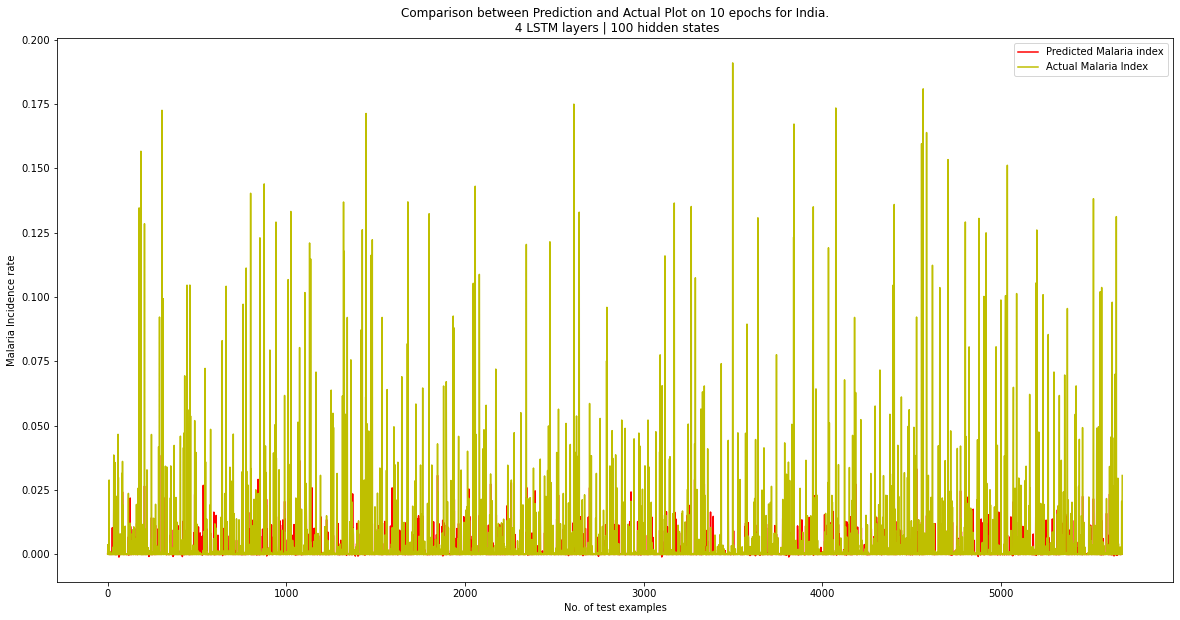

In [16]:
np.asarray(yhat).flatten()
np.asarray(ys).flatten()
saved_nm = './Graphs/actualVspred/'+country+'_'+str(loaded_model_epochs)+'_'+str(num_layers)+ '_' + str(hidden_size) + '_plot.png'
# previous_epochs
plt.figure(figsize=(20,10))
plt.plot(yhat,'r', label = 'Predicted Malaria index')
plt.plot(ys, 'y', label = 'Actual Malaria Index')
plt.legend()
plt.xlabel('No. of test examples')
plt.ylabel('Malaria Incidence rate')
plt.title(f'Comparison between Prediction and Actual Plot on {loaded_model_epochs} epochs for {country}.\n {num_layers} LSTM layers | {hidden_size} hidden states')
plt.savefig(saved_nm)
plt.show()

In [17]:
# Reset the Model_log.csv file
def create_new_log():
    df_log = pd.DataFrame(columns = [])
    df_log.to_csv('model_log.csv')
# Uncomment the following to create new log file
# create_new_log()

In [18]:
mae_loss = mean_absolute_error(ys,yhat)
print('Mean Absolute Error = ', mae_loss)

Mean Absolute Error =  0.004441626481242439


In [19]:
mse_loss = mean_squared_error(ys,yhat)
print('Mean Squared Error = ', mse_loss)

Mean Squared Error =  0.00027506594866925086


In [20]:
rmse_loss = np.sqrt(mean_squared_error(ys,yhat))
print('Root Mean Squared Error = ', rmse_loss)

Root Mean Squared Error =  0.01658511225977234


In [21]:
# Add a row entry in the model_log.csv file
dict = [{
    'country':country,
    'epochs': loaded_model_epochs,
    # 'threshold': tol,
    # 'train_loss': loss.item(),
    'accuracy(%)': acc,
    # 'mean_abs_err': mae_loss,
    # 'mean_sqr_err': mse_loss,
    'root_mean_sqr_err': rmse_loss,
    'lstm_units':hidden_size,
    'lstm_layers':num_layers,
    # 'Split type': split_type,
    # 'Train Split': train_split,
    # 'Test Split': 1-train_split
}]
df_entry = pd.DataFrame(dict)
# Reading recorded log
df_log = pd.read_csv('model_log.csv', index_col=0)
# Adding to the recorded log
df_log = pd.concat([df_log, df_entry])
df_log.to_csv('model_log.csv')
df_log

,country,epochs,accuracy(%),root_mean_sqr_err,lstm_units,lstm_layers
0,Pakistan,10,8.881579,0.012768,100,1
0,Pakistan,10,42.434211,0.008125,100,2
0,Pakistan,10,73.684211,0.009521,100,3
0,Pakistan,10,80.592105,0.007671,100,4
0,Pakistan,10,6.907895,0.012322,200,1
0,Pakistan,10,17.105263,0.008812,200,2
0,Pakistan,10,70.065789,0.007452,200,3
0,Pakistan,10,63.157895,0.009317,200,4
0,Pakistan,20,81.250000,0.008418,200,4
0,Bangladesh,10,99.115044,0.001608,100,4


In [22]:
test_size = test_X.shape[0]
ser_lst = []
for i in range(test_size):
    ser={
        'latnum':test_X[i][-1][0].item(),
        'longnum':test_X[i][-1][1].item(),
        'actual':ys[i][0],
        'predicted':yhat[i][0]
    }
    ser_lst.append(ser)

In [23]:
df_comp = pd.DataFrame(ser_lst)
df_comp.to_csv(f'./saved_results/{country}_{str(loaded_model_epochs)}_{str(num_layers)}_{str(hidden_size)}_actualVsPred.csv')